## 1. Set up the experiment


Zero-shot superresolution of the `GNO` model: From `(16, 16)` grid to `(64, 64)` grid.

### 1-1. Import modules

In [1]:
import  os, time
from    pathlib             import  Path
from    tqdm.notebook       import  tqdm
import  pickle
import  matplotlib.pyplot   as      plt

import  numpy                       as  np
import  torch
from    torch                       import  nn
from    torch_geometric.data        import  Data
from    torch_geometric.loader      import  DataLoader

import  yaml

from    custom_modules.dtypes               import  MultiLevelGraph
from    custom_modules.utils                import  GaussianNormalizer, npzReader
from    custom_modules.utils                import  RandomMultiGridGenerator
from    custom_modules.pytorch.neuralop     import  MultipoleGraphNeuralOperator    as  MGNO
from    custom_modules.pytorch.torch_utils  import  count_parameters

### 1-2. Load the configurations

In [2]:
with open("config_test.yaml") as f:
    config = yaml.load(f, Loader = yaml.FullLoader)
    _exp   = config['experiment']
    _data  = config['pde_dataset']
    _graph = config['graph']
    _mgno  = config['mgno']
    train_prefix = config['train_prefix']

### 1-3. Set the experiment

In [3]:
# NOTE Training and data preprocess


BATCH_SIZE      = _exp['batch_size']
TEST_SIZE       = _exp['test_size']
DEVICE          = torch.device(f"cuda:{_exp['cuda_index']}")


RESOLUTION      = _data['resolution']
TEST_PATH       = Path(_data['path'])
TEST_MASK       = np.random.choice(1024, TEST_SIZE, replace = False)


DOWNSAMPLE      = _data['downsample']
GRID            = (RESOLUTION - 1) // DOWNSAMPLE + 1
NUM_NODES       = GRID ** 2


RADII_GEOMETRIC = _graph['radii_geometric']
SAMPLE_SIZES    = _graph['sample_sizes']
NUM_SAMPLING    = _graph['num_sampling']
MAX_NEIGHBORS   = _graph['max_neighbors']

In [4]:
### NOTE Model instantiation
def get_path(train_grid: int) -> str:
    return f"{train_prefix}/gno_darcy{RESOLUTION}_res{train_grid}"


mgno = MGNO(**_mgno)
mgno.load_state_dict(torch.load(f"{get_path(31)}.pth"))
mgno.to(DEVICE)

print(f"The number of the parameters in the custom MGNO\n>>> {count_parameters(mgno)}")
print(mgno)

The number of the parameters in the custom MGNO
>>> 701457
MultipoleGraphNeuralOperator(
    lift:       MLP(layer=(6, 16, 32), bias=True, activation=relu)
    hidden:     MultipoleGraphKernelLayer(node_channels=32, edge_channels=6, n_poles=3 (down: 2, iso: 3, up: 2)) x 2 (activation=relu)
    projection: MLP(layer=(32, 16, 1), bias=True, activation=relu)
)


### * Report the train history

In [5]:
# Train history
with open(f"{get_path(31)}.pickle", "rb") as f:
    custom_train_history = pickle.load(f)

# Number of epochs
NUM_TRAIN_EPOCHS = len(custom_train_history['train_loss'])
_epoch_list = np.arange(NUM_TRAIN_EPOCHS) + 1

# Training time
print(f"Custom model    : {custom_train_history['train_time']:.2f} seconds")


# Plot
# fig, axes = plt.subplots(2, 1, figsize = (16, 10))
# axes[0].plot(_epoch_list, custom_train_history['val_loss'], c = 'r', label = "Custom")
# axes[0].set_title("Validation loss")
# axes[0].set_yscale("log")
# axes[0].legend()
# axes[1].plot(_epoch_list, custom_train_history['val_error'], c = 'r', label = "Custom")
# axes[1].set_title("Validation error")
# axes[1].set_yscale("log")
# axes[1].legend()
# plt.show()

Custom model    : 379.81 seconds


## 2. Preprocess data

### 2-1. Instantiate the storages

In [6]:
test_data: dict[str, torch.Tensor]= {
    'coeff':    None,
    'Kcoeff':   None,
    'Kcoeff_x': None,
    'Kcoeff_y': None,
    'sol':      None,
}


# # Normalizers
# normalizer: dict[str, GaussianNormalizer] = torch.load(f"{get_path(61)}_normalizer.pth")

### 2-2. Load the train data

In [7]:
# Test data
reader = npzReader(TEST_PATH)
for cnt, k in tqdm(enumerate(test_data.keys()), desc = "Preprocessing the test data"):
    # Step 1. Load data
    test_data[k] = torch.from_numpy(reader.get_field(k))
    test_data[k] = test_data[k][-TEST_SIZE:, ::DOWNSAMPLE, ::DOWNSAMPLE].flatten(-1)
    test_data[k] = test_data[k].type(torch.float)
    
    # # Step 2. Normalize data (NOTE: Uses the normalizers for the train dataset)
    # test_data[k] = normalizer[k].encode(test_data[k])

Preprocessing the test data: 0it [00:00, ?it/s]

### 2-3. Construct graphs

In [8]:
# NOTE Generate a grid to set the node and edge attributes

grid_generator  = RandomMultiGridGenerator([[0., 1.], [0., 1.]], [GRID, GRID], radii_geometric = RADII_GEOMETRIC, sample_sizes = [NUM_NODES // 8, NUM_NODES // 32, NUM_NODES // 128], max_neighbors = MAX_NEIGHBORS)

In [9]:
# NOTE Construct graphs


list_test_data = []

grid_generator.sample()
for idx in tqdm(range(TEST_SIZE)):
    # Input information
        _coeff      = test_data[ 'coeff'  ][idx].reshape(NUM_NODES, -1)
        _Kcoeff     = test_data['Kcoeff'  ][idx].reshape(NUM_NODES, -1)
        _Kcoeff_x   = test_data['Kcoeff_x'][idx].reshape(NUM_NODES, -1)
        _Kcoeff_y   = test_data['Kcoeff_y'][idx].reshape(NUM_NODES, -1)
        
        merged_grid_index       = grid_generator.merged_grid_index
        merged_graph_coords     = grid_generator.merged_graph_coordinates
        merged_graph_edge_index = grid_generator.merged_graph_edge_index
        
        merged_edge_index_in_grid = merged_grid_index[merged_graph_edge_index]

        # Define the node feature
        _x = torch.hstack(
            [
                merged_graph_coords,
                _coeff[merged_grid_index],
                _Kcoeff[merged_grid_index],
                _Kcoeff_x[merged_grid_index],
                _Kcoeff_y[merged_grid_index],
            ]
        )
        # Define the node target
        _y = test_data['sol'][idx].reshape(NUM_NODES, -1)[merged_grid_index]
        # Define the edge feature
        _edge_attr = torch.hstack(
            [
                merged_graph_coords[merged_graph_edge_index[0]],
                merged_graph_coords[merged_graph_edge_index[1]],
                _coeff[merged_edge_index_in_grid[0]],
                _coeff[merged_edge_index_in_grid[1]],
            ]
        )
        
        _ranges_node = grid_generator.masks_node
        _ranges_edge = grid_generator.masks_edge
        _lvwise_edge_index = grid_generator.levelwise_edge_index
        
        # Append the new graph
        list_test_data.append(
            Data(
                x = _x,
                y = _y,
                edge_index  = grid_generator.merged_graph_edge_index,
                edge_attr   = _edge_attr,
                
                mask_node  = _ranges_node,
                mask_edge  = _ranges_edge,
                levelwise_edge_index = _lvwise_edge_index,
            )
        )

  0%|          | 0/50 [00:00<?, ?it/s]

### 2-4. Instantiate dataloaders

In [10]:
test_loader  = DataLoader(list_test_data,  batch_size = BATCH_SIZE, shuffle = True)

## 3. Test the model

### 3-1. Initialize the loss function

In [11]:
criterion = nn.MSELoss(reduction = 'mean')

### 3-2. Test the model

In [12]:
# normalizer['sol'].to(DEVICE)


# NOTE: Test
mgno.eval()
with torch.no_grad():
    elapsed_time = time.time()

    test_epoch_loss:    torch.Tensor = 0
    test_epoch_error:   torch.Tensor = 0
    for batch in tqdm(test_loader, desc = "Test"):
        batch: Data = batch.to(DEVICE)
        
        test_pred = mgno.forward(batch)
        test_loss = criterion.forward(test_pred, batch.y)
        
        test_epoch_loss     = test_epoch_loss + test_loss * len(batch)
        # test_pred   = normalizer['sol'].decode(test_pred)
        # batch.y     = normalizer['sol'].decode(batch.y)
        test_epoch_error    = test_epoch_error + (
                                    torch.linalg.norm(test_pred - batch.y) / (1e-8 + torch.linalg.norm(batch.y))
                                ) * len(batch)
    test_epoch_loss     = test_epoch_loss / TEST_SIZE
    test_epoch_error    = test_epoch_error / TEST_SIZE
elapsed_time = time.time() - elapsed_time

print(f"* Elapsed time: {int(elapsed_time)} seconds")
print(f"* Test loss:    {test_epoch_loss.item():.4e}")
print(f"* L^2 error:    {test_epoch_error.item():.4e}")

Test:   0%|          | 0/50 [00:00<?, ?it/s]

* Elapsed time: 1 seconds
* Test loss:    1.7662e+05
* L^2 error:    6.1901e+04


### 3-3. Plot some examples

IndexError: index 1981 is out of bounds for dimension 0 with size 1830

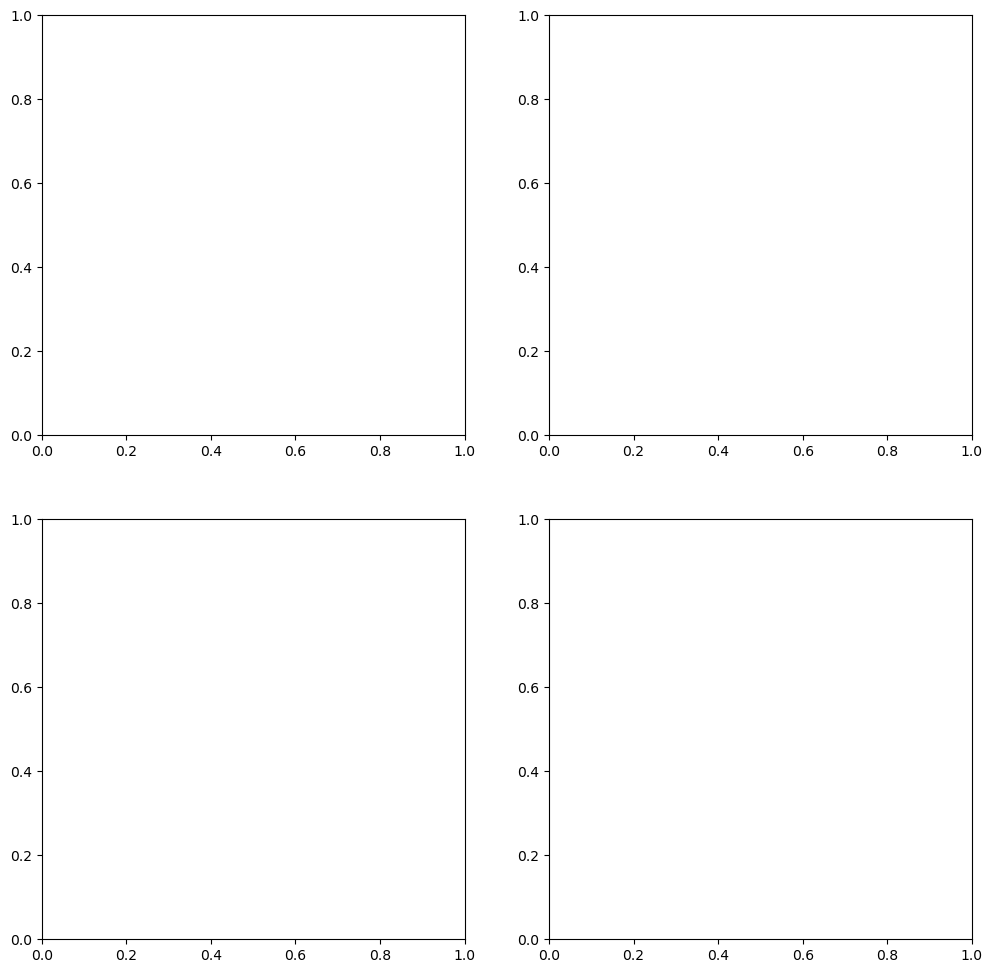

In [13]:
if True:
    EXAMPLE_IDX = 0
    example_range = slice(NUM_NODES * EXAMPLE_IDX, NUM_NODES * (EXAMPLE_IDX + 1))
    fig, axes = plt.subplots(2, 2, figsize = (12, 12))
    fullgrid = grid_generator.multigrid_index[0]


    example_y    = batch.y[example_range].cpu()[:len(fullgrid)]
    example_pred = test_pred[example_range].cpu()[:len(fullgrid)]
    example_y[grid_generator.multigrid_index[0]]    = example_y.clone()
    example_pred[grid_generator.multigrid_index[0]] = example_pred.clone()
    example_y    = example_y.reshape(GRID, GRID)
    example_pred = example_pred.reshape(GRID, GRID)

    im = axes[0, 0].imshow(example_y)
    axes[0, 0].set_title("Truth")
    plt.colorbar(im, ax = axes[0, 0])

    im = axes[0, 1].imshow(example_pred)
    axes[0, 1].set_title("Prediction")
    plt.colorbar(im, ax = axes[0, 1])

    im = axes[1, 0].imshow((example_pred - example_y).abs())
    axes[1, 0].set_title("$|(pred) - (truth)|$")
    plt.colorbar(im, ax = axes[1, 0])

    _vmax = 0.4
    im = axes[1, 1].imshow((example_pred - example_y).abs() / example_y.abs(), vmax = _vmax)
    axes[1, 1].set_title(f"$|(pred) - (truth)| / |(truth)|$ (bounded by {_vmax})")
    plt.colorbar(im, ax = axes[1, 1])

    plt.show()

## End of file